导入库

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import jieba
import wordcloud
import emoji


In [18]:
def clean_text(text: str, stopwords: list) -> str:
    """
    清洗文本，去除停用词、空行、多余空格、URL，以及表情符号和特殊符号。

    :param text: 需要清洗的文本
    :param stopwords: 停用词列表
    :return: 清洗后的文本
    """
    # 分词
    seg_list = jieba.cut(text)
    text = ' '.join(seg_list)

    # 去除 URL
    text = re.sub(r'http[s]?://\S+', '', text)

    # 去除多余空格
    text = re.sub(r'\s+', ' ', text).strip()

    # 去除表情符号
    text = emoji.replace_emoji(text, replace='')

    # 去除特殊符号）
    text = re.sub(r'[^\w\s\u4e00-\u9fa5]', '', text)

    # 按行分割，去除空行
    lines = [line.strip() for line in text.split('\n') if line.strip()]

    # 去除停用词
    clean_lines = []
    for line in lines:
        words = line.split()
        filtered_words = [word for word in words if word not in stopwords]
        clean_lines.append(' '.join(filtered_words))

    return '\n'.join(clean_lines)


导入数据

In [19]:
data = pd.read_csv("douban_reviews.csv", encoding="utf-8")
data["title"] = data["title"].astype(str)
data["review"] = data["review"].astype(str)
data["rating"] = data["rating"].replace("默认评分",0).astype(float)
data["upvote"] = data["upvote"].replace("默认赞成",0).astype(int)
data["downvote"] = data["downvote"].replace("默认反对",0).astype(int)
data["rating"] = data["rating"]/10

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811 entries, 0 to 2810
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     2811 non-null   object 
 1   rating    2811 non-null   float64
 2   upvote    2811 non-null   int32  
 3   downvote  2811 non-null   int32  
 4   review    2811 non-null   object 
dtypes: float64(1), int32(2), object(2)
memory usage: 88.0+ KB


In [20]:
data.describe()

,rating,upvote,downvote
count,2811.000000,2811.000000,2811.000000
mean,3.501957,9.788332,2.883671
std,1.695371,113.395803,46.641302
min,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,4.000000,1.000000,0.000000
75%,5.000000,2.000000,0.000000
max,5.000000,3263.000000,1821.000000


数据清洗

In [21]:
stopwords = [line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8').readlines()]
stopwords[:10]

['打开天窗说亮话',
 '到目前为止',
 '赶早不赶晚',
 '常言说得好',
 '何乐而不为',
 '毫无保留地',
 '由此可见',
 '这就是说',
 '这么点儿',
 '综上所述']

In [22]:
data['seg_review'] = data['review'].apply(lambda x: clean_text(x, stopwords))
# data.to_csv("douban_reviews_clean.csv", index=False, encoding="utf-8")
data.head()

,title,rating,upvote,downvote,review,seg_review
0,把仙翁塑造成世俗意义上的恶人，这个电影立意就落入俗套了,2.0,3123,1161,欢迎讨论，骂人的都反弹，看到的会删。\r\n\r\n\r\n电影里十二金仙说不能师出无名去剿...,讨论 骂人 反弹 删 电影 十二 金仙 说 师出无名 剿灭 龙族 太乙 真人 仙翁 说 仙翁...
1,哪吒反叛的力量：从弑父到弑神,5.0,1885,226,当银幕上哪吒在天元鼎内完成涅槃浴火重生时，相信所有人都会赞同，这绝不是一部普通的续作。时隔六...,银幕 哪吒 天元 鼎内 涅槃 浴火重生 时 所有人 赞同 一部 续作 时隔 六年 导演 饺子...
2,看过一天后，从三星降到两星，喜欢这部电影的这么多，不差我陈塘关百姓一个,2.0,3263,1821,这根本就是一部不该存在的续集，不过魔童降世实在太太太成功了，能怎么办呢。\r\n结果就是，哪...,根本就是 一部 不该 续集 魔童 降世 实在 太太 太 成功 哪吒 第二部 主线 故事 没 ...
3,唯余叹息——哪吒2的成功是快餐流量的狂欢，也是对电影艺术的侮辱,2.0,2362,829,哪吒2开分8.5，大感震惊，似乎与我观影感受有所出入，特来交流一番。（加更：墙裂恳请认同的点...,哪吒 开分 85 大感 震惊 观影 感受 出入 特 交流 加 更 墙裂 恳请 认同 点赞 转...
4,合格的商业片，但仍想提出质疑,3.0,1093,263,作为贺岁档电影，哪吒无疑是一部合格的商业片。故事节奏快，至少看着不会无聊，围绕亲情...,贺岁 档 电影 哪吒 无疑 一部 合格 商业片 故事 节奏快 至少 看着 无聊 围绕 亲情 ...


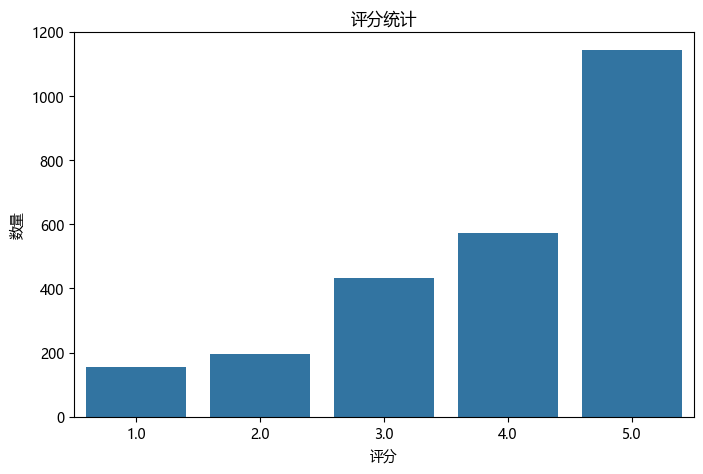

In [23]:
# rating分布特征 仅保留 rating > 0 的数据
ratings = data["rating"].dropna()
ratings = ratings[ratings > 0]

plt.figure(figsize=(8, 5))
sns.countplot(x=ratings, order=sorted(ratings.unique()))
plt.xlabel("评分")
plt.ylabel("数量")
plt.title("评分统计")
plt.show()


In [24]:
# 词云
def get_word_cloud(text):
    wc_stopwords = ["中","说","没","更","时"]
    wc = wordcloud.WordCloud(
        stopwords=wc_stopwords,
        font_path="msyh.ttc",
        width=800,
        height=400,
        background_color="white",
        mask=plt.imread("nezha.jpg"),
        max_words=100,
        random_state=42,
    )
    wc.generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

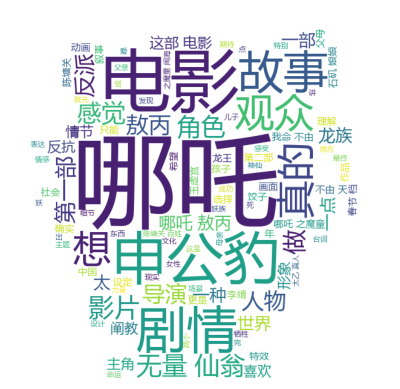

In [25]:
# # 高分词云
# good_reviews=data[data["rating"]>3]["seg_review"].str.cat(sep=" ")
# get_word_cloud(good_reviews)
# # 低分词云
# bad_reviews=data[data["rating"]<=3]["seg_review"].str.cat(sep=" ")
# get_word_cloud(bad_reviews)

get_word_cloud(data["seg_review"].str.cat(sep=" "))

In [26]:
guoman = data[(data["title"].str.contains("国漫")) & (data["review"].str.contains("国漫"))]
guoman.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 37 to 2792
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       37 non-null     object 
 1   rating      37 non-null     float64
 2   upvote      37 non-null     int32  
 3   downvote    37 non-null     int32  
 4   review      37 non-null     object 
 5   seg_review  37 non-null     object 
dtypes: float64(1), int32(2), object(3)
memory usage: 1.7+ KB


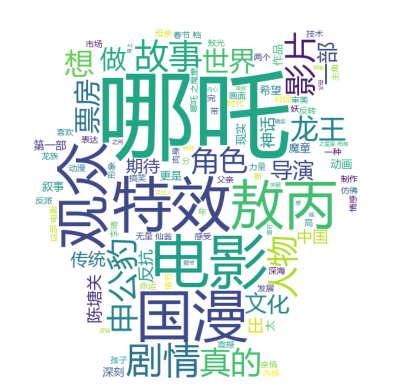

In [27]:
guoman_reviews = guoman["seg_review"].str.cat(sep=" ")
get_word_cloud(guoman_reviews)

LDA模型分析

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

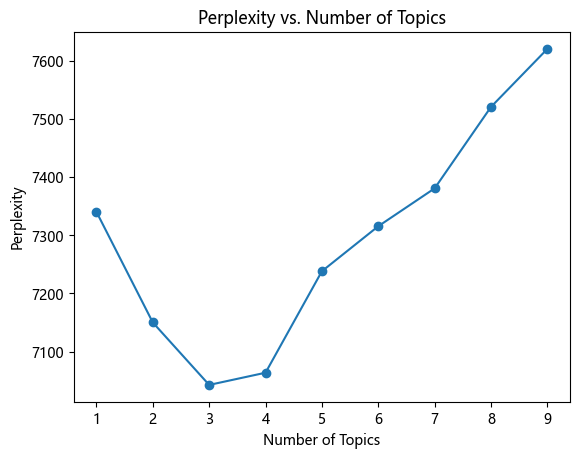

In [29]:
# 将文本转换为词袋模型
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["seg_review"])

# 尝试不同的主题数量
n_topics_range = range(1,10,1)
perplexities = []

for n_topics in n_topics_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    perplexities.append(lda.perplexity(X))

# 绘制困惑度曲线
plt.plot(n_topics_range, perplexities, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Number of Topics')
plt.show()

In [34]:
# 设置主题数量
n_topics = 4

# 训练LDA模型
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# 获取每个主题的关键词
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

n_top_words = 10
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words)

Topic #0: 哪吒 嘻嘻 申公豹 仙翁 棒棒 金仙 十二 封神 真人 太乙
Topic #1: 哪吒 申公豹 电影 敖丙 陈塘关 剧情 真的 故事 角色 父母
Topic #2: 哪吒 仙翁 反抗 电影 神话 社会 无量 阐教 中国 传统
Topic #3: 哪吒 电影 观众 剧情 中国 动画 故事 票房 特效 一部


In [35]:
# 为每条影评分配主题
topic_distribution = lda.transform(X)

# 获取每条影评的主要主题
data['main_topic'] = topic_distribution.argmax(axis=1)

In [36]:
data.head()

,title,rating,upvote,downvote,review,seg_review,main_topic
0,把仙翁塑造成世俗意义上的恶人，这个电影立意就落入俗套了,2.0,3123,1161,欢迎讨论，骂人的都反弹，看到的会删。\r\n\r\n\r\n电影里十二金仙说不能师出无名去剿...,讨论 骂人 反弹 删 电影 十二 金仙 说 师出无名 剿灭 龙族 太乙 真人 仙翁 说 仙翁...,2
1,哪吒反叛的力量：从弑父到弑神,5.0,1885,226,当银幕上哪吒在天元鼎内完成涅槃浴火重生时，相信所有人都会赞同，这绝不是一部普通的续作。时隔六...,银幕 哪吒 天元 鼎内 涅槃 浴火重生 时 所有人 赞同 一部 续作 时隔 六年 导演 饺子...,2
2,看过一天后，从三星降到两星，喜欢这部电影的这么多，不差我陈塘关百姓一个,2.0,3263,1821,这根本就是一部不该存在的续集，不过魔童降世实在太太太成功了，能怎么办呢。\r\n结果就是，哪...,根本就是 一部 不该 续集 魔童 降世 实在 太太 太 成功 哪吒 第二部 主线 故事 没 ...,3
3,唯余叹息——哪吒2的成功是快餐流量的狂欢，也是对电影艺术的侮辱,2.0,2362,829,哪吒2开分8.5，大感震惊，似乎与我观影感受有所出入，特来交流一番。（加更：墙裂恳请认同的点...,哪吒 开分 85 大感 震惊 观影 感受 出入 特 交流 加 更 墙裂 恳请 认同 点赞 转...,1
4,合格的商业片，但仍想提出质疑,3.0,1093,263,作为贺岁档电影，哪吒无疑是一部合格的商业片。故事节奏快，至少看着不会无聊，围绕亲情...,贺岁 档 电影 哪吒 无疑 一部 合格 商业片 故事 节奏快 至少 看着 无聊 围绕 亲情 ...,1


In [37]:
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
# 可视化LDA模型
pyLDAvis.lda_model.prepare(lda, X, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.087878 -0.003601       1        1  47.406066
3      0.116832  0.087737       2        1  28.508823
2      0.024806 -0.114990       3        1  21.335735
0     -0.229517  0.030854       4        1   2.749376, topic_info=      Term         Freq        Total Category  logprob  loglift
40901   电影  6835.000000  6835.000000  Default  30.0000  30.0000
7289    仙翁  2180.000000  2180.000000  Default  29.0000  29.0000
4639    中国  2217.000000  2217.000000  Default  28.0000  28.0000
12757   动画  1665.000000  1665.000000  Default  27.0000  27.0000
12419   剧情  2962.000000  2962.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
19530   天道    13.682108   121.195897   Topic4  -7.2142   1.4125
22212  封神榜    14.012978   155.801062   Topic4  -7.1903   1.1852
20677   妖族    14.857962   801.827843   Topic4  -7.1317  -0.3946
42645   石矶    14.470527   742.973588   Topic4  -7.1582  -0.3448
7176    仙丹    12.943169   375.305750   Topic4  -7.2697   0.2266

[370 rows x 6 columns], token_table=       Topic      Freq Term
term                       
26         1  0.391727   10
26         2  0.494322   10
26         3  0.037307   10
26         4  0.074615   10
293        2  0.940573   3a
...      ...       ...  ...
58059      4  0.007895   龙族
58090      1  0.815347   龙王
58090      2  0.070977   龙王
58090      3  0.103804   龙王
58090      4  0.009759   龙王

[747 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])